In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.dataset import random_split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

from keras.utils.np_utils import to_categorical  

from torchsummary import summary

from torch.optim import lr_scheduler

import time

In [ ]:
# Enable gpu support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Data extraction and preprocessing

In [ ]:
data = pd.read_csv('data/train.csv')


In [ ]:
display(data.head())
data.shape

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


(28709, 2)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB


In [ ]:
X = np.array([
              [i for i in map(int, row)] for row 
              in map(str.split, data['pixels'])
      ]).reshape((-1, 48, 48))

In [ ]:
X

array([[[ 70,  80,  82, ...,  52,  43,  41],
        [ 65,  61,  58, ...,  56,  52,  44],
        [ 50,  43,  54, ...,  49,  56,  47],
        ...,
        [ 91,  65,  42, ...,  72,  56,  43],
        [ 77,  82,  79, ..., 105,  70,  46],
        [ 77,  72,  84, ..., 106, 109,  82]],

       [[151, 150, 147, ..., 129, 140, 120],
        [151, 149, 149, ..., 122, 141, 137],
        [151, 151, 156, ..., 109, 123, 146],
        ...,
        [188, 188, 121, ..., 185, 185, 186],
        [188, 187, 196, ..., 186, 182, 187],
        [186, 184, 185, ..., 193, 183, 184]],

       [[231, 212, 156, ...,  44,  27,  16],
        [229, 175, 148, ...,  27,  35,  27],
        [214, 156, 157, ...,  28,  22,  28],
        ...,
        [241, 245, 250, ...,  57, 101, 146],
        [246, 250, 252, ...,  78, 105, 162],
        [250, 251, 250, ...,  88, 110, 152]],

       ...,

       [[ 74,  81,  87, ..., 189, 191, 192],
        [ 78,  82,  89, ..., 185, 189, 193],
        [ 81,  86,  94, ..., 176, 185, 193

In [ ]:
X.shape

(28709, 48, 48)

In [ ]:
y = data['emotion']
display(y.value_counts())
y = y.values

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

# Dataset

In [133]:
class EmotionsDataset(Dataset):
  def __init__(self, X, y, transform=None):
    self.transform = transform

    self.X = X
    self.y = y

    self.X_tensor = torch.from_numpy(X).float().to(device).unsqueeze(1)
    self.y_tensor = torch.from_numpy(to_categorical(y, num_classes=7)).float().to(device)
    
    # if self.transform:
    #   self.cached = {id(i) for i in self.y}
    #   self.cache = [self.transform(tensor).to(device) for tensor in self.X_tensor]
  
  def __len__(self):
    return len(self.y)
  
  def __getitem__(self, index):
    X, y = self.X_tensor[index], self.y_tensor[index]

    if not self.transform:
      return X, y

    X = self.transform(X)

    return X, y

  # def get_dataset(self, with_transform=False):
  #   if with_transform and self.transform:
  #     X_tensor = torch.from_numpy(self.X).float().unsqueeze(0)

  #     return self.transform(X_tensor).squeeze(0), self.y
    
  #   return self.X, self.y

In [ ]:
# counts = np.unique(data.y, return_counts=True)[1]
# class_weights = np.power(counts, -1, dtype=float)

# data.raw_getitem = True
# sample_weights = [class_weights[label] for i, (_, label) in enumerate(data)]
# data.raw_getitem = False

# sampler = WeightedRandomSampler(sample_weights, 
#                                 num_samples=len(sample_weights),
#                                 replacement=True)

# loader = DataLoader(data, batch_size=2048, sampler=sampler)


# Data visualisation

In [ ]:
target_names = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral',
}

In [ ]:
def plot_images(dataset, classes=7, columns=5):
  _X = np.zeros((classes * columns, 48, 48))
  _y = []

  X, y = dataset

  for label in range(classes):
    mask = (y == label)
    _X[columns * label : columns * label + columns] = X[mask, :][:columns]
    _y.extend([label] * columns)

  _, axes = plt.subplots(nrows=classes, ncols=columns, figsize=(15, 15))
  for ax, image, label in zip(axes.flatten(), _X, _y):
      ax.set_xticks([])
      ax.set_yticks([])
      ax.imshow(image, cmap=plt.cm.gist_gray)
      ax.set_title(target_names[label])

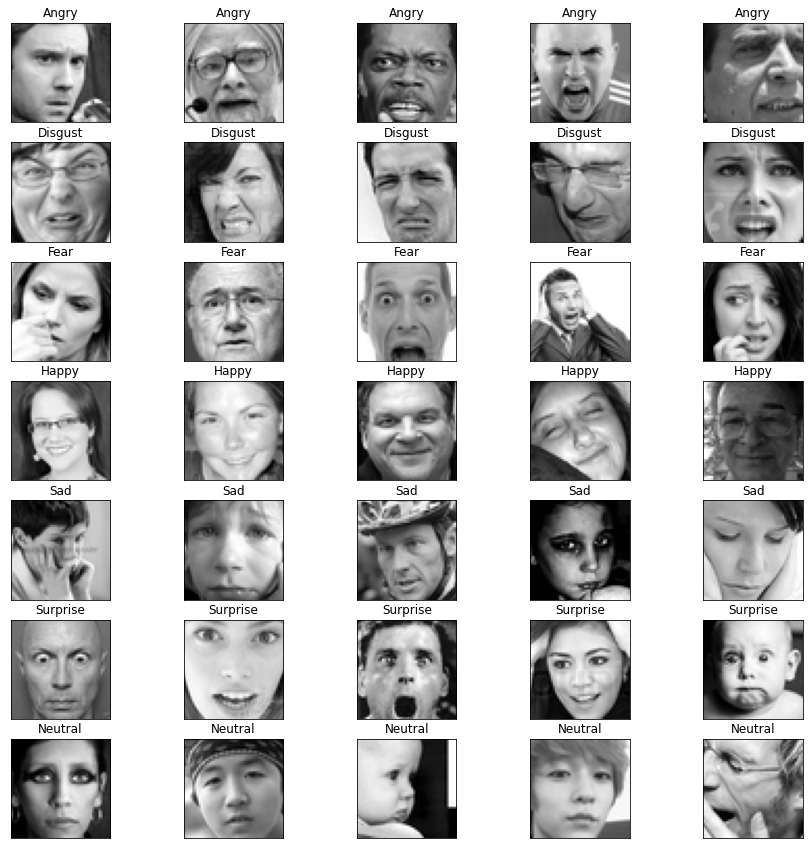

In [ ]:
plot_images(data.get_dataset())

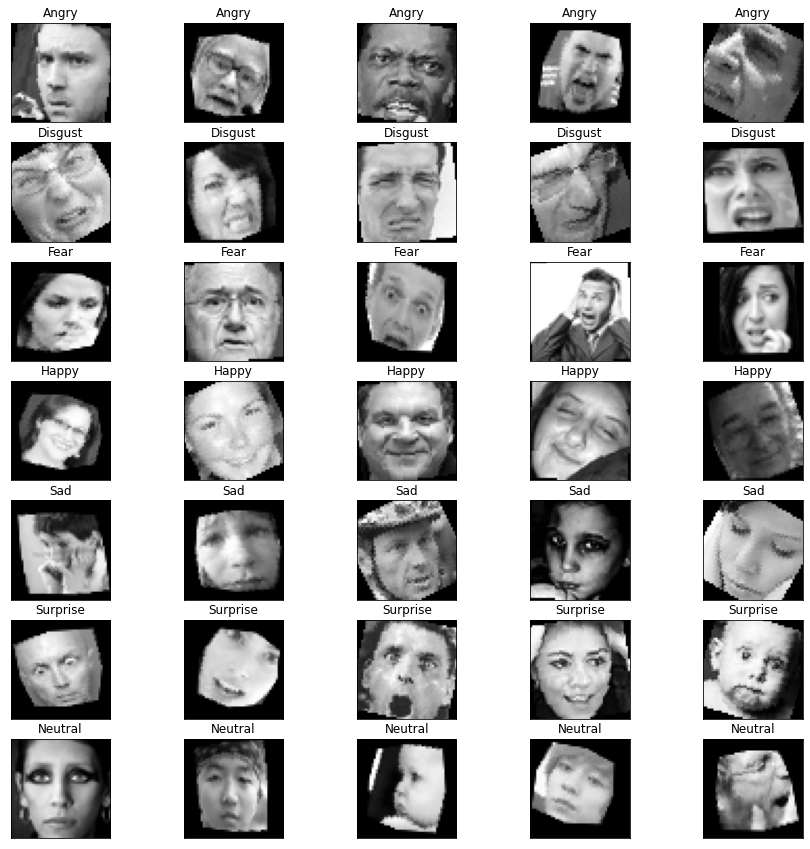

In [ ]:
# Play with transforms
transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(degrees=(-30, 30)),
      transforms.RandomPerspective(distortion_scale=0.35),

    ])

data.transform = transform
data_loader = DataLoader(data, batch_size=2048)

for X, y in data_loader:
  X = X.squeeze(1).cpu()
  y = np.argmax(y.cpu(), axis=1)

  plot_images((X, y))
  break


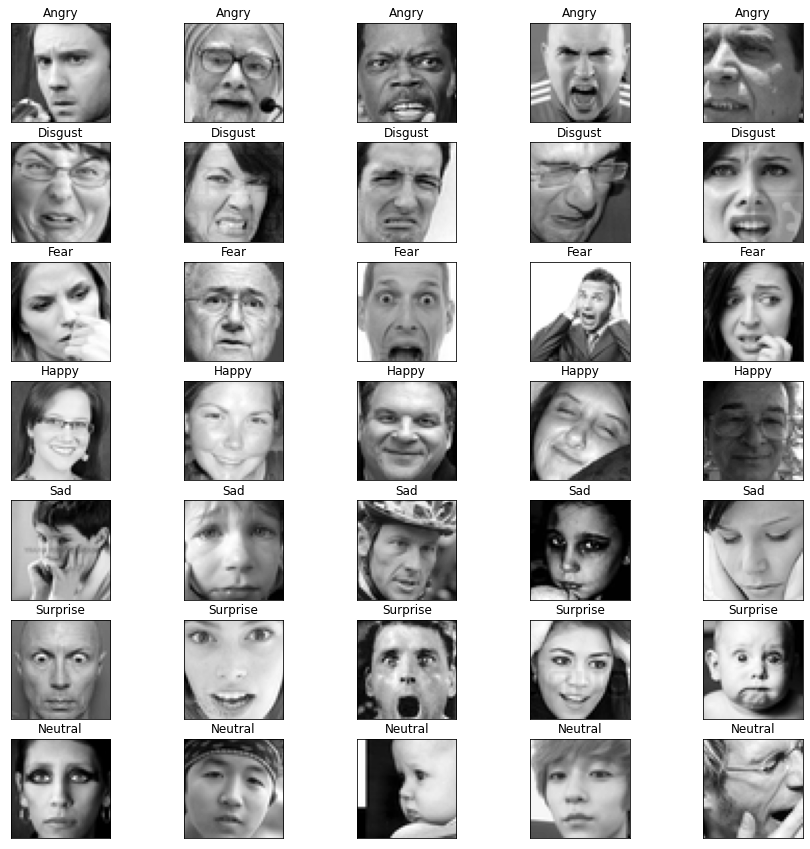

In [ ]:
from torchvision.transforms.transforms import ToTensor
transform = transforms.Compose([
      transforms.RandomHorizontalFlip(p=1),
      transforms.RandomPerspective(distortion_scale=0.35)
    ])

data.transform = transform
plot_images(data.get_dataset(with_transform=True))

# Models

In [157]:
class Net(nn.Module):
  def __init__(self, backbone):
    super(Net, self).__init__()
    
    # last layer
    backbone.fc = nn.Linear(backbone.fc.in_features, 7, bias=True)

    self.model = nn.Sequential(
        # first layer (mapping grayscale pictures to 3 channels)
        nn.Conv2d(1, 3, 1),
        backbone,
        # nn.Softmax(dim=1)
    )

    # for param in self.model[1].parameters():
    #   param.requires_grad = False

  def forward(self, x):
    return self.model(x)

In [190]:
# Testing model
def test_model(model, test_loader, return_predictions=False):
    print('\n* Model testing * ')

    predictions = []
    model.eval()

    for images, _ in test_loader: 
      with torch.no_grad(): 
        outputs = model(images)

        predicted = torch.max(outputs.data, 1)[1]
        predictions.extend(map(int, predicted))
    
    model.train()
    
    if return_predictions:
      return metrics.accuracy_score(test_loader.dataset.y, predictions), predictions
    else:
      return metrics.accuracy_score(test_loader.dataset.y, predictions)

In [212]:
# Training model
def train_model(model, criterion, optimizer, scheduler, train_loader, test_loader,
                transform, epochs=1000):
    print('\n* Model training * ')

    train_accuracy_list = []
    test_accuracy_list = []
    loss_list = np.empty((epochs, len(train_loader)))
    
    model.train()
    for epoch in range(epochs):
        print(f'\t* epoch #{epoch + 1}')
        for batch, (images, labels) in enumerate(train_loader):
          
          optimizer.zero_grad()
          
          # forward
          outputs = model(images)
          loss = criterion(outputs, labels)

          # backward
          loss.backward()

          optimizer.step()
          scheduler.step()

          loss_list[epoch][batch] = loss

        # validation
        test_period = 1
        if epoch % test_period == 0:
          train_accuracy_list.append(test_model(model, train_loader))
          test_accuracy_list.append(test_model(model, test_loader))
          pass

    return loss_list.mean(axis=1), train_accuracy_list, test_accuracy_list

In [161]:
def plot_confusin_matrix(y_real, y_test):
  confusion_matrix = metrics.confusion_matrix(y_real, y_test)
  sns.heatmap(confusion_matrix, center=0, cmap='PiYG', annot=True)

  plt.show()

In [174]:
def plot_loss(loss: np.array):
  x = [i for i in range(1, len(loss) + 1)]

  plt.xlabel('epoch')
  plt.ylabel('loss')

  plt.plot(x, loss)
  plt.show()

In [216]:
def run_pipeline(
    X,
    y,
    model=models.resnet18(pretrained=True), 
    batch_size=2048,
    lr=0.001,
    epochs=1,
    show_summary=False,
    random_state=42,
    step_size=25,
    gamma=1):
    
    # Data splitting
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_test, y_test, test_size=0.5, stratify=y_test, random_state=random_state
    )

    # Augmentation
    transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(degrees=(-30, 30)),
      transforms.RandomPerspective(distortion_scale=0.35),
    ])

    train = EmotionsDataset(X_train, y_train, transform)
    val = EmotionsDataset(X_val, y_val)
    test = EmotionsDataset(X_test, y_test)

    # Sampler
    counts = np.unique(y_train, return_counts=True)[1]
    class_weights = np.power(counts, -1, dtype=float)

    sample_weights = [class_weights[label] for i, label in enumerate(y_train)]

    sampler = WeightedRandomSampler(sample_weights, 
                                num_samples=len(sample_weights),
                                replacement=True)

    # DataLoaders
    train_loader = DataLoader(train,
                              batch_size=batch_size,
                              sampler=sampler)
    val_loader = DataLoader(val,
                            batch_size=batch_size,
                            shuffle=False)
    test_loader = DataLoader(test,
                             batch_size=batch_size,
                             shuffle=False)

    # Model
    net = Net(backbone=model).float().to(device)
    
    # Model summary
    if show_summary:
        summary(net, (1, 48, 48))

    # Error
    error=nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    # Scheduler
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    # Training
    loss, train_acc, test_acc = train_model(net, 
                      error, 
                      optimizer, 
                      scheduler, 
                      train_loader, 
                      val_loader,
                      transform, 
                      epochs)
    # Testing
    accuracy, predictions = test_model(net, test_loader, return_predictions=True)
    print('Accuracy: ', accuracy)

    # Plots
    plot_confusin_matrix(y_test, predictions)
    plot_loss(loss)

    return loss, train_acc, test_acc


* Model training * 
	* epoch #1

* Model testing * 

* Model testing * 
	* epoch #2

* Model testing * 

* Model testing * 

* Model testing * 
Accuracy:  0.4043887147335423


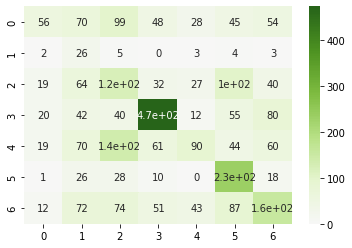

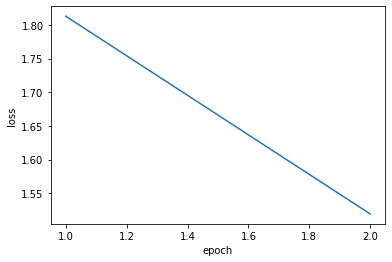

In [217]:
loss, train_acc, test_acc = run_pipeline(X, y, model=models.resnet18(pretrained=True), show_summary=False,
             epochs=2, batch_size=2048, lr=0.0005)

In [183]:
test_accuracy

[]


* Model training * 
	* epoch #1
	* epoch #2
	* epoch #3
	* epoch #4
	* epoch #5
	* epoch #6
	* epoch #7
	* epoch #8
	* epoch #9
	* epoch #10
	* epoch #11
	* epoch #12
	* epoch #13
	* epoch #14
	* epoch #15
	* epoch #16
	* epoch #17
	* epoch #18
	* epoch #19
	* epoch #20
	* epoch #21
	* epoch #22
	* epoch #23
	* epoch #24
	* epoch #25
	* epoch #26
	* epoch #27
	* epoch #28
	* epoch #29
	* epoch #30
	* epoch #31
	* epoch #32
	* epoch #33
	* epoch #34
	* epoch #35
	* epoch #36
	* epoch #37
	* epoch #38
	* epoch #39
	* epoch #40
	* epoch #41
	* epoch #42
	* epoch #43
	* epoch #44
	* epoch #45
	* epoch #46
	* epoch #47
	* epoch #48
	* epoch #49
	* epoch #50

* Model testing * 
	* batch #1
	* batch #2
	* batch #3
Accuracy:  0.5905607802159526


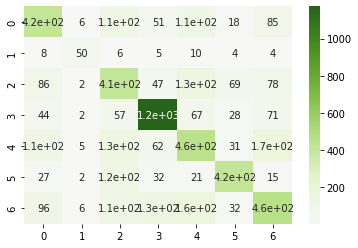

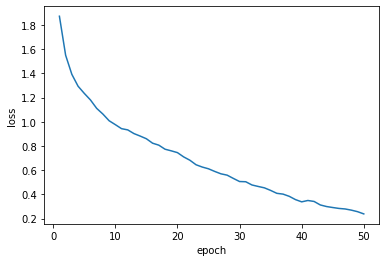

In [ ]:
run_pipeline(X, y, model=models.resnet18(pretrained=True), show_summary=False,
             epochs=50, batch_size=2048, lr=0.0005)

In [ ]:
# Previous train below


* Model training * 
	* epoch #1
	* epoch #2
	* epoch #3
	* epoch #4
	* epoch #5
	* epoch #6
	* epoch #7
	* epoch #8
	* epoch #9
	* epoch #10
	* epoch #11
	* epoch #12
	* epoch #13
	* epoch #14
	* epoch #15
	* epoch #16
	* epoch #17
	* epoch #18
	* epoch #19
	* epoch #20
	* epoch #21
	* epoch #22
	* epoch #23
	* epoch #24
	* epoch #25
	* epoch #26
	* epoch #27
	* epoch #28
	* epoch #29
	* epoch #30

* Model testing * 
	* batch #1
	* batch #2
	* batch #3
Accuracy:  0.588470916057123


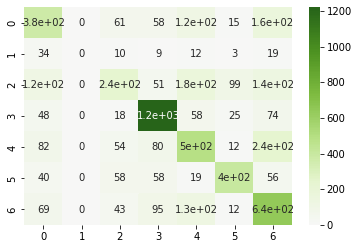

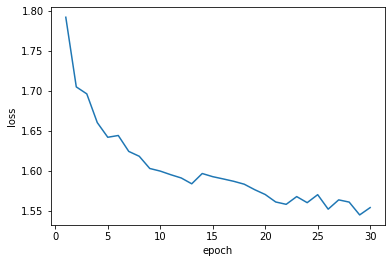

In [ ]:
run_pipeline(X, y, model=models.resnet18(pretrained=True), show_summary=False,
             epochs=30, batch_size=2048, lr=0.0005)


* Model training * 
	* epoch #1


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


	* epoch #2
	* epoch #3
	* epoch #4
	* epoch #5
	* epoch #6
	* epoch #7
	* epoch #8
	* epoch #9
	* epoch #10
	* epoch #11
	* epoch #12
	* epoch #13
	* epoch #14
	* epoch #15
	* epoch #16
	* epoch #17
	* epoch #18
	* epoch #19
	* epoch #20
	* epoch #21
	* epoch #22
	* epoch #23
	* epoch #24
	* epoch #25
	* epoch #26
	* epoch #27
	* epoch #28
	* epoch #29
	* epoch #30

* Model testing * 
	* batch #1
	* batch #2
	* batch #3
Accuracy:  0.5989202368512714


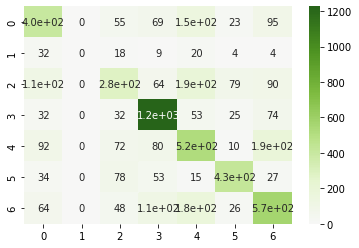

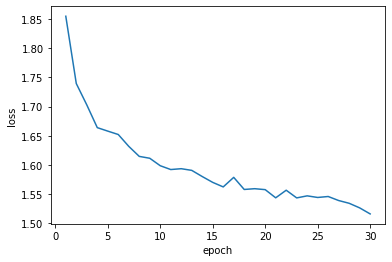

In [ ]:
run_pipeline(X, y, model=models.googlenet(pretrained=True), epochs=30, batch_size=2048, lr=0.0005)

# Some thoughts about project improvements.

Firstly, we need to specify much larger epoch rate (in this work it's not quite enough, due to the power and time limitations).<br>
Inception model is not used because image size is too small for that model (MaxPool2d layers reduce our image size too much).<br>
Considered models have their own traits & features, but for our task their behaviour tends to be almost the same. <br><br>
To try to improve model efficiency we can add some custom layers above our backbone model.<br><br>
In out dataset we've got a class imbalance:<br>
7215 images for emotion "happy" (class 3)<br>
436 images for emotion "disgust" (class 1)<br>
~3000-5000 for other emotions<br><br>
As a result, accuracy is not a good option as a main metric (as we see our badly trained models mostly ignores classes apart from "happy", and we can assume that trained model could neglect of taking into accout emotion "disgust" and still have a good accuracy score).
To overcome this problem we can use recall score with micro-averaging, or other metrics such as F1-score, ROC/ROC AUC etc.<br><br>
To overcome imbalance we can also reduce the biggest classes, or use on the smallest classes such technics as augmentation more, or use that two methods simultaneously. <br><br>
Also, it's nice to have validations during training, and afterwards we can use that information for plot relationship between epochs and training & validation scores. (I decided not to use it and commented it in order not to raise model complexity)

# Conlusions
During this project, i have got better understanding of Tensorflow, Keras (initially used it for current project and coded a simple model via it) and PyTorch (switched to PyTorch afterwards). In the process of completing study, I get acquainted with Google Colaboratory, different neural networks, aspecially with classifiers with backbone architecture such as ResNet, EfficientNet, Inception & GoggleNet. Learned terminology, built models, trained them and evaluated on test data, suggested base improvements & thoughts.